# Agent Learning Project

## Imports 

We start by importing the required libaries. Uncomment & run the next cell in case some of the libraries aren't installed in your environment. 

In [1]:
# !pip install numpy matplotlib

In [2]:
import numpy as np # Useful for computations and probabilistic distributions
import matplotlib.pyplot as plt # Plotting Graph for Simulation results
import statistics # Useful to get statistics at the end of the Simulation
import tkinter as tk # Graphical Interface library 
from collections import defaultdict # Specific kind of dictionary that avoids KeyErrors

## Defining the Agent class

We define a type of agent with the following attributes: 
- Agent name : Name of the agent
- Service probability : If at the counter, shows the probability that this agent will be serviced.
- Reward : Reward the counter gets for servicing this agent
- Time in queue : Time for which the agent has been in the queue. 

In [3]:
class Agent:
    def __init__(self, agent_name):
        self.agent_name = agent_name
        self.service_prob = agents[agent_name][0]
        self.reward = agents[agent_name][1]
        self.penalty = agents[agent_name][2]
        self.time_in_queue = 0

    def __str__(self):
        return f"Agent {self.agent_name} ({self.time_in_queue})"

## Defining the Queue mechanism 

In [65]:
class QueueSimulation:
    def __init__(self, agents, arrival_prob, strategy, init, alpha, discount):
        # Define the agents, their distribution, and the strategy
        self.agents = agents
        self.agent_distribution = np.array([agent[3] for agent in agents.values()])
        self.agent_distribution = self.agent_distribution / np.sum(self.agent_distribution)
        self.strategy = strategy
        
        # Define the hyper-parameters of the simulation
        self.arrival_prob, self.init, self.alpha, self.discount = arrival_prob, init, alpha, discount
        
        # Define the Queue
        self.queue = [self.create_agent() for _ in range(init)] if type(init) == int else init
        self.current_agent = None if len(self.queue) == 0 else self.queue[0]
        
        # Variables that are used to analyze our code
        self.time, self.busy, self.total_reward, self.discounted_reward = 0, 0, 0, 0
        
        # Tracking the history for graphs
        self.serviced_agents = defaultdict(int)
        self.reward_history, self.queue_length_history = [], []

    def create_agent(self):
        agent_name = np.random.choice(list(self.agents.keys()), p=self.agent_distribution)
        return Agent(agent_name)

    def step(self):
        """
        This function is the core of the simulation. It defines what happens at every step. The order in which 
        the computations are made is important so we have to be careful. In our case, we proceed as follows:
        
        1. Determine whether an agent is joining the queue
        2. Detemine if the agent in service is going to complete service or not and potentially add reward 
        3. Apply the given strategy to determine what happens next
        4. Add penalty to the reward
        5. Add the information related to the step to the simulation history
        
        Please feel free to ask for any changes in the implementation
        """
        # Add new agent to the queue based on arrival probability
        if np.random.rand() < self.arrival_prob:
            new_agent = self.create_agent()
            self.queue.append(new_agent)

        # Check if the current agent is done being served
        if self.current_agent:
            if np.random.rand() < self.current_agent.service_prob:
                self.total_reward += self.current_agent.reward
                self.discounted_reward += self.current_agent.reward* discount**self.time
                self.serviced_agents[self.current_agent.agent_name] += 1
                self.current_agent = None
                
        # Apply the strategy to select the next agent
        if self.queue:
            queue_index = self.strategy(self.queue,self.current_agent)
            self.swap_agents(queue_index)

        # Apply penalty on reward
        self.time += 1
        self.discount *= self.discount # Optimization trick (do * itself instead of recomputing the power)
        for agent in self.queue: 
            agent.time_in_queue += 1
            self.total_reward -= agent.penalty
            self.discounted_reward -= agent.penalty*self.discount
        self.total_reward -= regularization(self.alpha,len(self.queue))
        self.discounted_reward -= regularization(self.alpha,len(self.queue))*self.discount
        
        # Add the step's information to the simulation history
        self.reward_history.append(self.total_reward)
        self.queue_length_history.append(len(self.queue)+bool(self.current_agent))
        self.busy += bool(self.current_agent)
        

    def get_queue_status(self):
        return [str(agent) for agent in self.queue]

    def get_current_agent(self):
        return str(self.current_agent) if self.current_agent else "None"

    def get_total_reward(self):
        return self.total_reward
    
    def get_discounted_reward(self):
        return self.discounted_reward

    def swap_agents(self, queue_index):
        if 0 <= queue_index < len(self.queue):
            if self.current_agent:
                self.queue[queue_index], self.current_agent = (self.current_agent,self.queue[queue_index])
            else:
                self.current_agent = self.queue.pop(queue_index)

    def run_simulation(self, steps=1000):
        for _ in range(steps):
            self.step()

    def get_results(self):
        # Plot total reward over time
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.reward_history)
        plt.title('Total Reward over Time')
        plt.xlabel('Time')
        plt.ylabel('Total Reward')

        # Plot queue length over time
        plt.subplot(1, 3, 2)
        plt.plot(self.queue_length_history)
        plt.title('Queue Length over Time')
        plt.xlabel('Time')
        plt.ylabel('Queue Length')

        # Plot distribution of serviced agents by type
        plt.subplot(1, 3, 3)
        agent_types, counts = zip(*sorted(self.serviced_agents.items()))
        plt.bar(agent_types, counts)
        plt.title('Distribution of Serviced Agents by Type')
        plt.xlabel('Agent Type')
        plt.ylabel('Count')

        plt.tight_layout()
        plt.show()
        
        self.total_reward = self.get_total_reward()
        self.min_queue_length = np.min(self.queue_length_history)
        self.max_queue_length = np.max(self.queue_length_history)
        self.mean_queue_length = np.median(self.queue_length_history)
        self.normalized_distribution = {agent_type: round(count / sum(self.serviced_agents.values()), 3) for agent_type, count in sorted(self.serviced_agents.items(), key=lambda item: item[1], reverse=True)}

        
        print(f"\nTotal reward of r = {self.total_reward}")
        print(f"Discounted reward of r = {self.discounted_reward}")
        print(f"Min & Max Queue Length: {self.min_queue_length} & {self.max_queue_length}")
        print(f"Mean Queue Length: {self.mean_queue_length}")
        print(f"Normalized Distribution of Serviced Agents: {self.normalized_distribution}")
        print(f"Time spent busy: {self.busy/self.time}")
        print(f"--------------------------------------------------------")


In [66]:
# Compute average service probability
def service():
    service_prob = np.array([agent[0] for agent in agents.values()])
    weights = np.array([agent[3] for agent in agents.values()])
    distribution = weights / np.sum(weights)
    x = np.dot(service_prob, distribution.T)
    return x

# Compute expect reward per agent
def average():
    probabilities = np.array([agent[0] for agent in agents.values()])
    rewards = np.array([agent[1] for agent in agents.values()])
    penalties = np.array([agent[2] for agent in agents.values()])
    average_values = {agent: (rewards[i] + penalties[i]) / probabilities[i] for i, agent in enumerate(agents.keys())}
    return average_values

## Designing our Graphical User Interface

In [67]:
class QueueSimulationGUI:
    def __init__(self, master, simulation):
        self.master = master
        self.simulation = simulation
        self.master.title("Queue Simulation")

        # Frame for displaying the time
        self.time_frame = tk.Frame(master)
        self.time_frame.pack(pady=10)

        self.time_label = tk.Label(self.time_frame, text="Time: 0", font=("Helvetica", 14))
        self.time_label.pack()

        # Frame for displaying the queue with scrollable canvas
        self.queue_frame = tk.Frame(master)
        self.queue_frame.pack(pady=10, fill=tk.BOTH, expand=True)

        self.queue_label = tk.Label(
            self.queue_frame,
            text=f"Queue - Length: {len(self.simulation.queue)}",
            font=("Helvetica", 14),)
        self.queue_label.pack()

        self.queue_canvas = tk.Canvas(self.queue_frame, width=600, height=150, bg="white")
        self.queue_canvas.pack(side=tk.TOP, fill=tk.BOTH, expand=True) 

        self.scrollbar = tk.Scrollbar(self.queue_frame, orient=tk.HORIZONTAL, command=self.queue_canvas.xview)
        self.scrollbar.pack(side=tk.TOP, fill=tk.X)  # Change from BOTTOM to TOP
        
        self.queue_canvas.config(xscrollcommand=self.scrollbar.set)

        self.inner_queue_frame = tk.Frame(self.queue_canvas)
        self.queue_canvas.create_window((0, 0), window=self.inner_queue_frame, anchor='nw')

        # Frame for displaying the current agent at the counter
        self.counter_frame = tk.Frame(master)
        self.counter_frame.pack(pady=10)

        self.counter_label = tk.Label(self.counter_frame, text="Counter", font=("Helvetica", 14))
        self.counter_label.pack()

        self.counter_canvas = tk.Canvas(self.counter_frame, width=200, height=100, bg="white")
        self.counter_canvas.pack()

        # Frame for displaying the total reward
        self.reward_frame = tk.Frame(master)
        self.reward_frame.pack(pady=10)

        self.reward_label = tk.Label(self.reward_frame, text="Total Reward: 0", font=("Helvetica", 14))
        self.reward_label.pack()

        # Frame for action buttons
        self.action_frame = tk.Frame(master)
        self.action_frame.pack(pady=10)

        self.next_step_button = tk.Button(self.action_frame, text="Next Step", command=self.next_step)
        self.next_step_button.pack(side=tk.LEFT, padx=10)

        self.reset_button = tk.Button(self.action_frame, text="Reset", command=self.reset_simulation)
        self.reset_button.pack(side=tk.LEFT, padx=10)

        # Frame for input and switch button
        self.input_frame = tk.Frame(master)
        self.input_frame.pack(pady=10)

        self.index_label = tk.Label(self.input_frame, text="Enter Queue Index:", font=("Helvetica", 14))
        self.index_label.pack(side=tk.LEFT)

        self.index_entry = tk.Entry(self.input_frame, width=5)
        self.index_entry.pack(side=tk.LEFT, padx=5)

        self.switch_button = tk.Button(self.input_frame, text="Switch", command=self.switch_agent)
        self.switch_button.pack(side=tk.LEFT, padx=10)

        self.reset_simulation()

    def next_step(self):
        self.simulation.step()
        self.update_labels()

    def switch_agent(self):
        try:
            agent_index = int(self.index_entry.get())
            self.simulation.swap_agents(agent_index)
            self.update_labels()
        except Exception:
            pass  # We could imagine adding an error message here

    def update_labels(self):
        self.time_label.config(text=f"Time: {self.simulation.time}")
        self.reward_label.config(text=f"Total Reward: {self.simulation.get_total_reward()}")
        self.queue_label.config(text=f"Queue - Length: {len(self.simulation.queue)}",)

        # Update queue visualization
        self.queue_canvas.delete("all")
        box_width = 150
        for idx, agent in enumerate(self.simulation.queue):
            self.queue_canvas.create_rectangle(10 + box_width * idx, 10, box_width + box_width * idx, 60, fill="lightblue")
            self.queue_canvas.create_text(10 + box_width * idx + box_width / 2, 35, text=str(agent))

        self.queue_canvas.config(scrollregion=self.queue_canvas.bbox("all"))

        # Update counter visualization
        self.counter_canvas.delete("all")
        if self.simulation.current_agent:
            self.counter_canvas.create_rectangle(50, 10, 150, 60, fill="lightgreen")
            self.counter_canvas.create_text(100, 35, text=str(self.simulation.current_agent.agent_name))
        else:
            self.counter_canvas.create_text(100, 35, text="Empty")

    def reset_simulation(self):
        self.simulation = QueueSimulation(
            self.simulation.agents,
            self.simulation.arrival_prob,
            self.simulation.strategy,
            self.simulation.init,
            self.simulation.alpha,
            self.simulation.discount,
        )
        self.update_labels()


## Defining strategies

In [68]:
def priority_list(queue, current_agent):
    if current_agent:
        current_priority = fixed_priority.index(current_agent.agent_name)
        min_queue_priority = min(fixed_priority.index(agent.agent_name) for agent in queue)
        if current_priority <= min_queue_priority:
            return -1
    return min(range(len(queue)), key=lambda i: fixed_priority.index(queue[i].agent_name))

def first_in_first_served(queue, current_agent):
    if current_agent:
        return -1
    return 0

def dynamic_strategy(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: current_agent.time_in_queue if i == -1 else queue[i].time_in_queue)
    return max(range(len(queue)), key=lambda i: queue[i].time_in_queue)

def shortest_service_time_first(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: current_agent.service_prob if i == -1 else queue[i].service_prob)
    return max(range(len(queue)), key=lambda i: queue[i].service_prob)

def highest_reward_first(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: current_agent.reward if i == -1 else queue[i].reward)
    return max(range(len(queue)), key=lambda i: queue[i].reward)

def random_selection(queue, current_agent):
    return np.random.randint(-1, len(queue)) if current_agent else np.random.randint(0, len(queue))

def dynamic_priority(queue, current_agent):
    priority = {agent: agents[agent][0] * agents[agent][2] for agent in agents}
    priority = sorted(priorities.keys(), key=lambda agent: priorities[agent], reverse=True)
    if current_agent:
        current_priority = priority.index(current_agent.agent_name)
        min_queue_priority = min(priority.index(agent.agent_name) for agent in queue)
        if current_priority <= min_queue_priority:
            return -1
    return min(range(len(queue)), key=lambda i: priority.index(queue[i].agent_name))

### Explanations of strategies

- **priority_list**: Selects agents based on a predefined priority list.
- **first_in_first_served**: Selects the first agent in the queue.
- **dynamic_strategy**: Selects the agent who has been waiting the longest.
- **shortest_service_time_first**: Selects the agent with the shortest service time.
- **highest_reward_first**: Selects the agent with the highest reward.
- **random_selection**: Selects an agent randomly from the queue.
- **dynamic_priority**: Best penalty to expected service time ratio

The next step could be to implement more complex dynamic strategies and Machine Learning based strategies.

## Choosing base parameters

In [69]:
# Defining Agents
agents = {
    ### Agent name : [service_probability, reward, penalty, distrib_weight]
    # service_probability: float in [0,1]
    # reward, penalty, distrib_weight: float (unconstrained)
    "Alex" : [0.7, 1, 0.1, 6], 
    "Ben" : [0.5, 20, 0.4, 3],
    "Cameron" : [0.3, 30, 0.2, 4],
    "Dennis" : [0.4, 20, 0.01, 2],
    "Eric": [0.8, 4, 0.2, 3],
    "Fabien": [0.5, 50, 0.4, 1],
}

# Expected average service probability & time
print(round(service(),5))

# Probabilty that a new agent joins the queue
arrival_prob = 0.5

# Number of agents in the queue at t = 0
# We either choose a random weighted queue or a specific queue
start = 0
queue = [Agent("Alex"),Agent("Cameron"),Agent("Ben"),Agent("Fabien")]
init = start # Choose a mode here

# Choose a discount factor for discounted reward computation
discount = 0.99

# Regularization parameter and function
alpha = 0.02
def regularization(alpha,length):
    return alpha*length

0.55789


## Playing the game manually

Execute the main code manually and play the game by making your own decisions through the graphical user interface.

In [70]:
should_run = False # Change should_run if you want to play manually
if should_run:
    strategy = first_in_first_served
    simulation = QueueSimulation(agents, arrival_prob, strategy, init, alpha, discount)
    root = tk.Tk()
    gui = QueueSimulationGUI(root, simulation)
    root.mainloop()

## Playing the game according to predetermined strategies

Execute the main code automatically by choosing one of the strategies defined above in the 'Define Strategies' section and letting the computer play by itself. This function outputs three graphs. 
- Graph 1: Total reward from time $t_0$ to time $t_{1000}$.
- Graph 2: Length of the Queue from time $t_0$ to time $t_{1000}$.
- Graph 3: Distribution of serviced Agents by type from $t_0$ to time $t_{1000}$.



### Running a specific strategy

Automatic simulation with strategy 'priority_list'
Expected service probability across agents: 0.55789
Expected reward + weighted penalty for each agent: {'Alex': 1.5714285714285716, 'Ben': 40.8, 'Cameron': 100.66666666666667, 'Dennis': 50.025, 'Eric': 5.25, 'Fabien': 100.8}


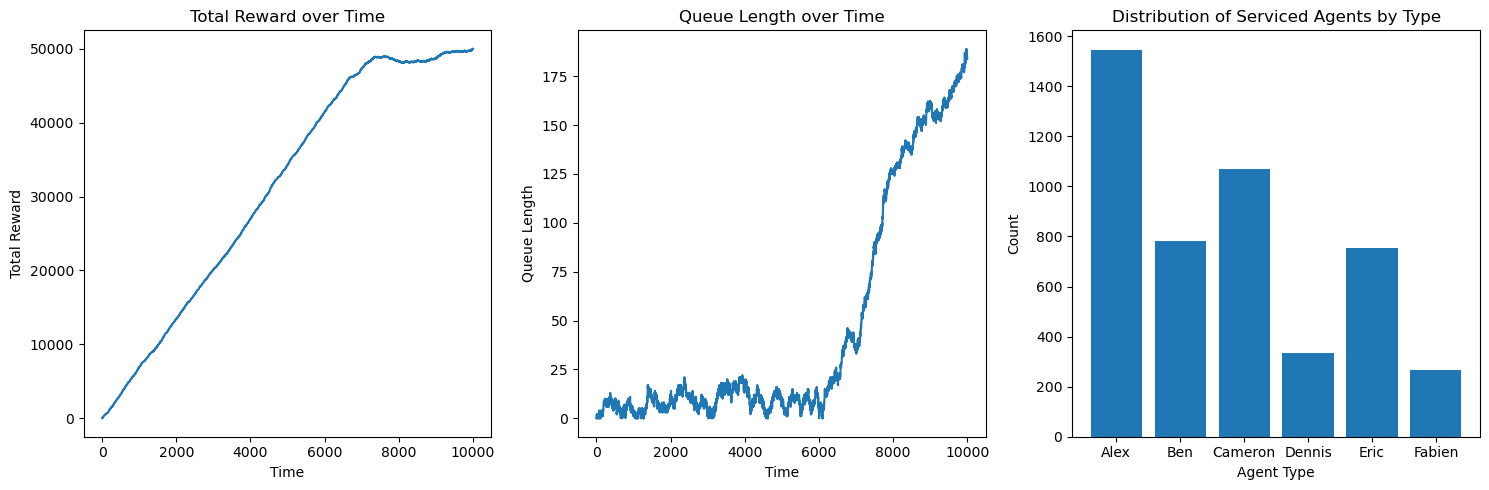


Total reward of r = 49973.78999935258
Discounted reward of r = 596.7053262124587
Min & Max Queue Length: 0 & 189
Mean Queue Length: 13.0
Normalized Distribution of Serviced Agents: {'Alex': 0.325, 'Cameron': 0.225, 'Ben': 0.164, 'Eric': 0.159, 'Dennis': 0.07, 'Fabien': 0.056}
Time spent busy: 0.989
--------------------------------------------------------


In [71]:
# Choosing the strategy (full list of strategies above)
fixed_priority = ["Fabien","Eric","Ben", "Alex",  "Cameron", "Dennis"]
strategy = priority_list

simulation = QueueSimulation(
    agents,
    arrival_prob,
    strategy,
    init,
    alpha,
    discount,
)

print(f"Automatic simulation with strategy '{strategy.__name__}'")
print(f"Expected service probability across agents: {round(service(),5)}")
print(f"Expected reward + weighted penalty for each agent: {average()}")
simulation.run_simulation(steps=10000)
simulation.get_results()

### Comparing strategies

Expected service time across agents: 0.55789
Expected reward + weighted penalty for each agent: {'Alex': 1.5714285714285716, 'Ben': 40.8, 'Cameron': 100.66666666666667, 'Dennis': 50.025, 'Eric': 5.25, 'Fabien': 100.8}
Running simulation with strategy 'priority_list'


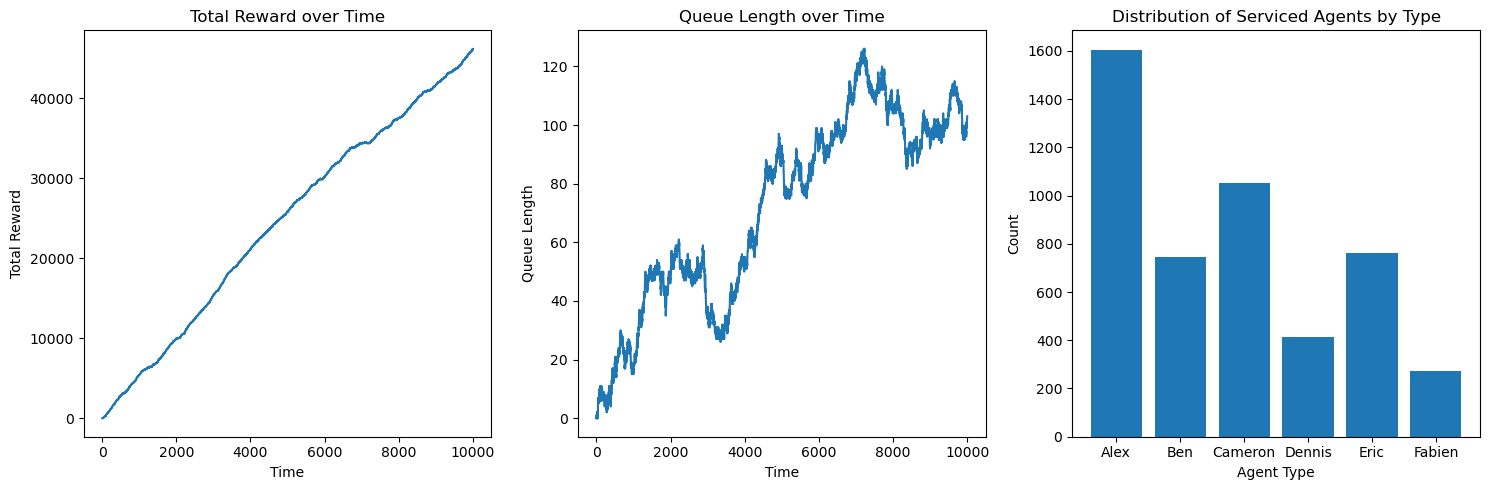


Total reward of r = 46202.33999963342
Discounted reward of r = 429.86456068021494
Min & Max Queue Length: 0 & 126
Mean Queue Length: 82.0
Normalized Distribution of Serviced Agents: {'Alex': 0.331, 'Cameron': 0.217, 'Eric': 0.157, 'Ben': 0.154, 'Dennis': 0.085, 'Fabien': 0.056}
Time spent busy: 0.9987
--------------------------------------------------------
Running simulation with strategy 'first_in_first_served'


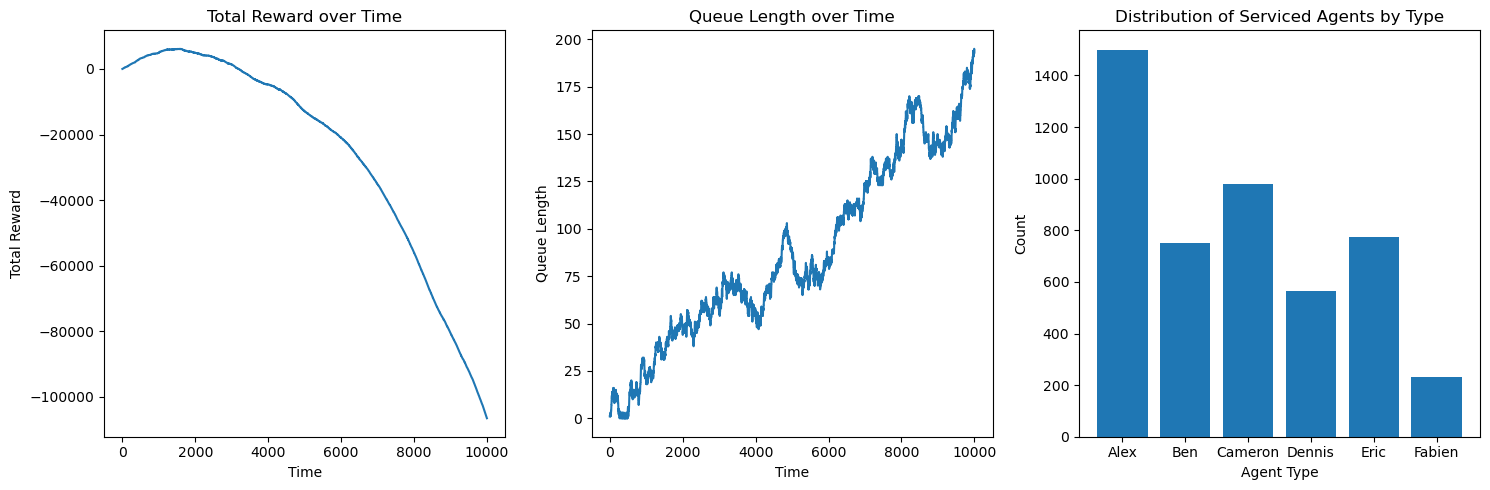


Total reward of r = -106536.82999951515
Discounted reward of r = 602.0950935917202
Min & Max Queue Length: 0 & 195
Mean Queue Length: 75.0
Normalized Distribution of Serviced Agents: {'Alex': 0.312, 'Cameron': 0.204, 'Eric': 0.161, 'Ben': 0.156, 'Dennis': 0.117, 'Fabien': 0.048}
Time spent busy: 0.9932
--------------------------------------------------------
Running simulation with strategy 'dynamic_strategy'


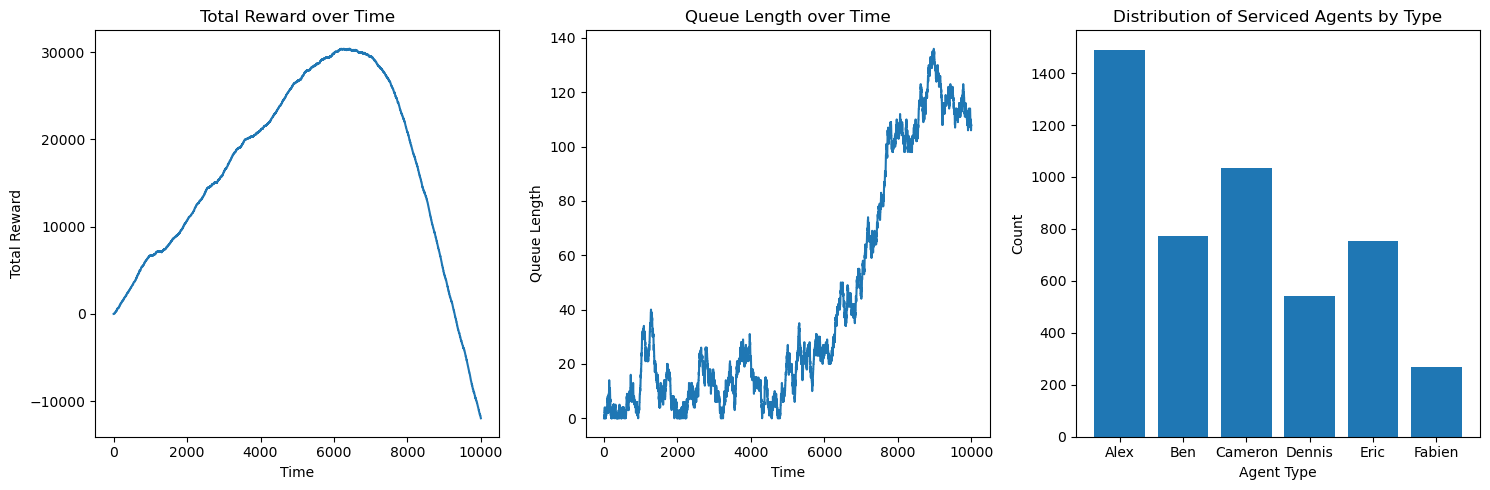


Total reward of r = -11954.920000012673
Discounted reward of r = 556.0390048008422
Min & Max Queue Length: 0 & 136
Mean Queue Length: 23.0
Normalized Distribution of Serviced Agents: {'Alex': 0.307, 'Cameron': 0.213, 'Ben': 0.159, 'Eric': 0.155, 'Dennis': 0.111, 'Fabien': 0.055}
Time spent busy: 0.9847
--------------------------------------------------------
Running simulation with strategy 'shortest_service_time_first'


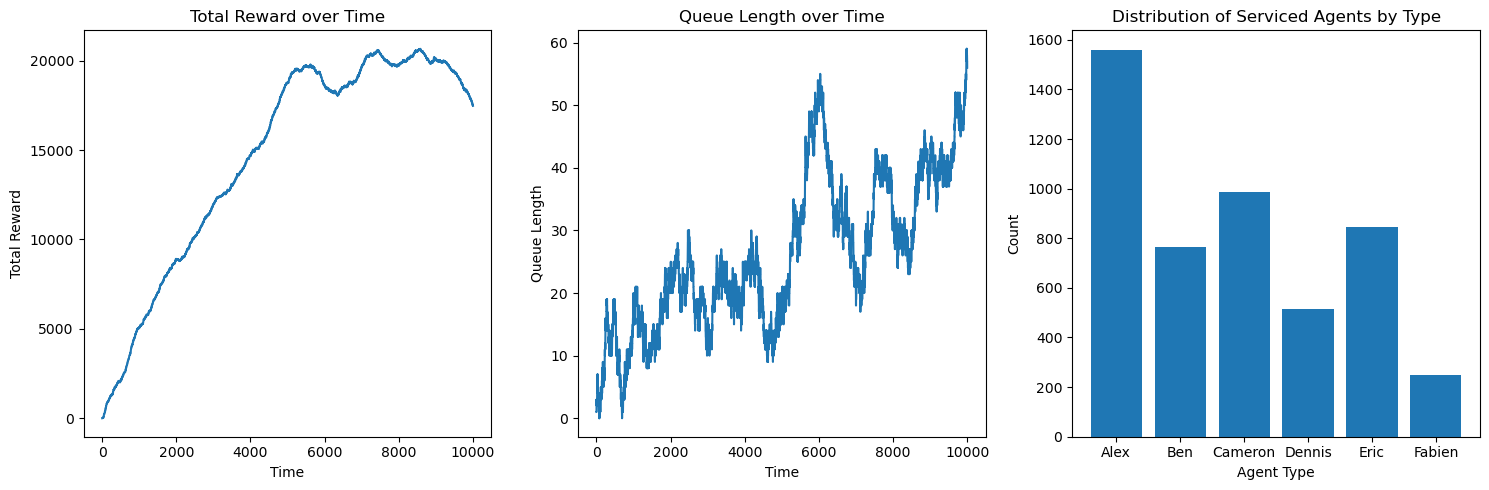


Total reward of r = 17478.179999837135
Discounted reward of r = 510.55229342952646
Min & Max Queue Length: 0 & 59
Mean Queue Length: 24.0
Normalized Distribution of Serviced Agents: {'Alex': 0.317, 'Cameron': 0.201, 'Eric': 0.172, 'Ben': 0.155, 'Dennis': 0.105, 'Fabien': 0.051}
Time spent busy: 0.9989
--------------------------------------------------------
Running simulation with strategy 'highest_reward_first'


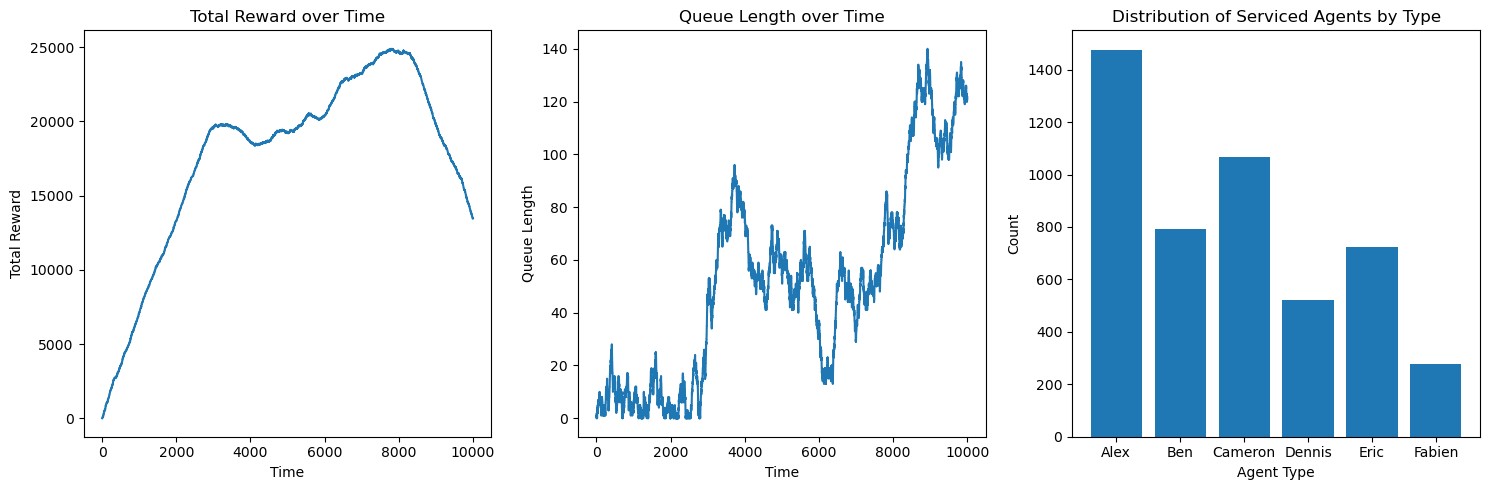


Total reward of r = 13445.600000586073
Discounted reward of r = 787.3105680372557
Min & Max Queue Length: 0 & 140
Mean Queue Length: 51.0
Normalized Distribution of Serviced Agents: {'Alex': 0.304, 'Cameron': 0.22, 'Ben': 0.163, 'Eric': 0.149, 'Dennis': 0.107, 'Fabien': 0.057}
Time spent busy: 0.9855
--------------------------------------------------------
Running simulation with strategy 'random_selection'


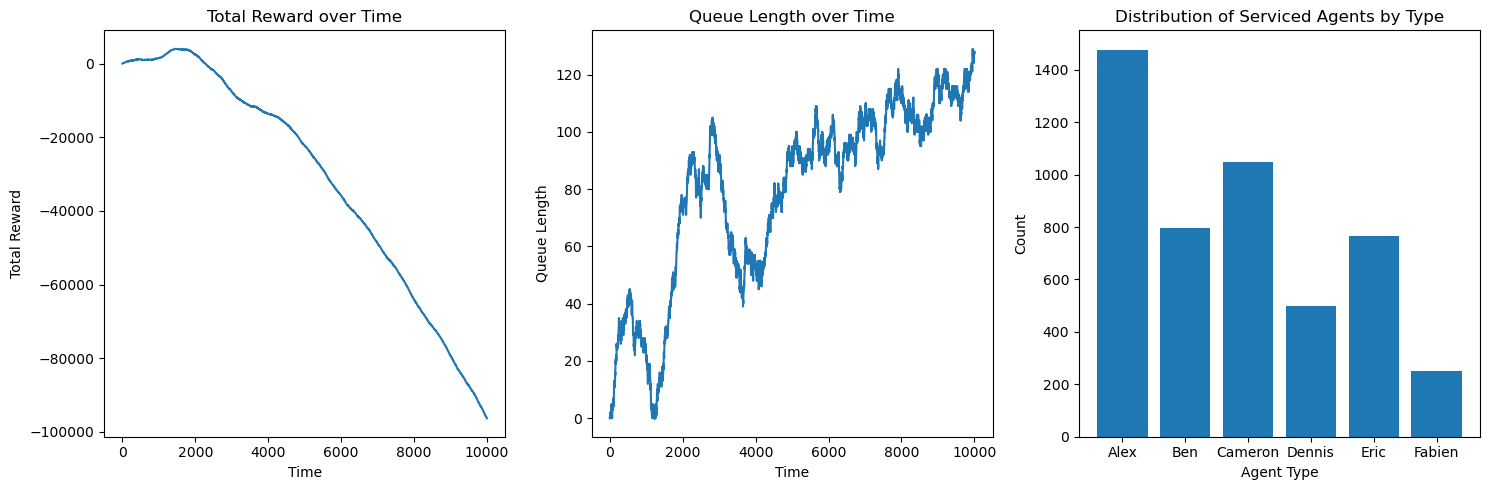


Total reward of r = -96286.44999936166
Discounted reward of r = 388.730842389357
Min & Max Queue Length: 0 & 129
Mean Queue Length: 90.0
Normalized Distribution of Serviced Agents: {'Alex': 0.305, 'Cameron': 0.217, 'Ben': 0.165, 'Eric': 0.158, 'Dennis': 0.103, 'Fabien': 0.052}
Time spent busy: 0.9969
--------------------------------------------------------


In [77]:
# Initialize a dictionary to store the results
results = {}

# Print the expected service time and reward + weighted penalty
print(f"Expected service time across agents: {round(service(), 5)}")
print(f"Expected reward + weighted penalty for each agent: {average()}")

# Add potential variables for some strategies
fixed_priority = ["Fabien", "Eric", "Ben", "Alex", "Cameron", "Dennis"]

# Define the strategies you want to compare
strategies = [
    ("priority_list", priority_list),
    ("first_in_first_served", first_in_first_served),
    ("dynamic_strategy", dynamic_strategy),
    ("shortest_service_time_first", shortest_service_time_first),
    ("highest_reward_first", highest_reward_first),
    ("random_selection", random_selection)
]

# Run the simulation for each strategy
for strategy_name, strategy in strategies:
    simulation = QueueSimulation(agents, arrival_prob, strategy, start, alpha, discount)
    
    print(f"Running simulation with strategy '{strategy_name}'")
    simulation.run_simulation(steps=10000)
    simulation.get_results()
    results[strategy_name] = (simulation.total_reward, simulation.discounted_reward)


### Statistics

Find the strategy with the most reward

In [75]:
metric = "discounted_reward" # Choose metric between 'total_reward' and 'discounted_reward'

# Find the strategy with the highest reward based on the selected metric
best_strategy = max(results.items(), key=lambda x: x[1][metric == 'discounted_reward'])
best_strategy_name, best_rewards = best_strategy

print(f"\nBest Strategy: {best_strategy_name} with (total, discounted) reward of {best_rewards}")


Best Strategy: highest_reward_first with (total, discounted) reward of (26851.190000427185, 676.6024698174851)


# Comments

In case something needs to be changed, please feel free to write something in the cell below and email me about it. 